# This is the multiple endurance tool
If it is the first time that you use Jupyter and Conda, you will need to install the package minimalmodbus. Search for the `ANACONDA POWER SHELL` in your system and launch: `pip install minimalmodbus`.

Most important things first: The class Quasar. Feel free to use this class in other scripts. It can be modified, but keep in mind that other users may loose backward compatibility.

**For rokies**, the Quasar class simply defines procedures, communication adresses and some other stuff needed to run the script safely. If you want to take a look on it, it should be placed in the same folder of the script. Otherwise it won't work. If you want to go even further and test some modifications in the class, substitute the following cell by: `%load QuasarClass.py` and run. The class will be shown as is in the python file.

In [1]:
%run -i "QuasarClass.py"


## Endurance in current mode

Data from TEST:
AC voltage: 240.8 V
AC current: 18.6 A
DC voltage: 358.8 V
DC current: 11.8 A
SoC:          0 %
Maximum temperature is:  53ºC

Current state:            1
Reported 0 errors, last was 1575471785s ago with code 0x0
Running time:       25 s
Remaining time:     57 s

Generate a failure to stop, i.e. disconnect usb cable (then wait 10s) or trip the AC breaker.
Terminating TEST...
Process TEST terminated in error
['Terminated by user']
Charger returned error code 0x0
Saving file...
Terminated


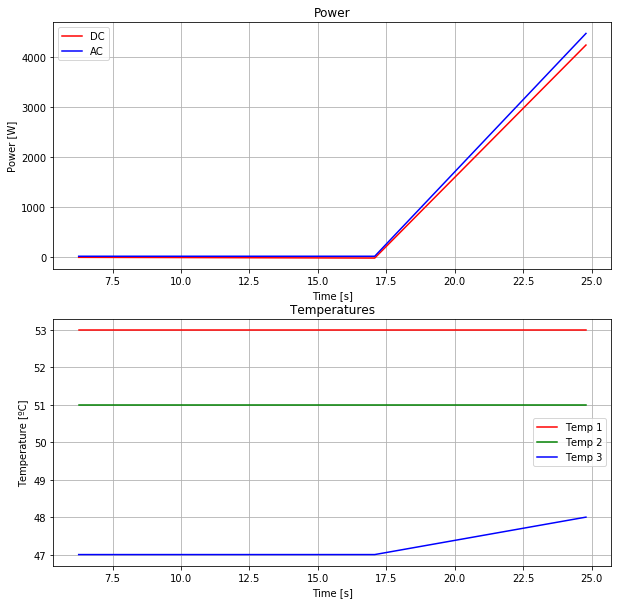

In [2]:
import time

# Third number is power
endurance_ops = []
for x in range(1):
    endurance_ops.append(["charge", 30, 90])
    endurance_ops.append(["rest", 30, 0])
    endurance_ops.append(["discharge", 30, 90])
    endurance_ops.append(["rest", 30, 0])

# Initialize the quasar. Arguments are: Name of the converter, port and slave number (keep 10)
p1 = quasar('TEST', 'COM6', 10)

# Put the password to unlock 
p1.unlock()

# Set the quasar in current mode
p1.set_current_mode()

# Checklist verifies that there is DC voltage and no errors
p1.checklist()

# From now on, executes the script
# Transform table in something machine friendly
machine_ops = []
acum_time = 0
for element in endurance_ops:
    acum_time += element[1]
    if element[0] == "charge":
        op = START
        multiplier = 1.0
    elif element[0] == "discharge":
        op = START
        multiplier = -1.0
    else:
        op = STOP
        multiplier = 0.0
    machine_ops.append([op,acum_time,multiplier*abs(element[2])])
# End of transformation


# Run the endurance
from IPython.display import clear_output
%matplotlib inline

start_time = time.time()
for element in machine_ops:
     while (time.time() - start_time < element[1]) and (not(p1.is_in_error())):
            p1.set_op(element[0]) # Basically, start and stop
            p1.set_current(17)    # No limit on current
            p1.set_power(element[2])  # Set the power according to the table
            p1.update_values() # Get values from the converter
            clear_output() # Clears the result of the cell. It creates the "update effect".
            p1.print_stats() # Some stats are printed using the class
            print ("Remaining time: {:6.0f} s".format(machine_ops[-1][1] - (time.time() - start_time)))
            print ("\nGenerate a failure to stop, i.e. disconnect usb cable (then wait 10s) or trip the AC breaker.")
            try:
                time.sleep(5)
                if p1.is_in_error():
                    p1.reset() # Reset manager is autonomous in the class. Resets are limited in number. 
            except KeyboardInterrupt:
                p1.raise_error("Terminated by user")
            
data = p1.terminate() # Stop the quasar
del p1 # Destroy the instance and free allocated memory

# Make some fancy plots
import matplotlib
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,10))
time = [element[0] for element in data]
dc_power = [element[6]*element[7] for element in data]
ac_power = [element[3]*element[4] for element in data]
plt.subplot(211)
plt.plot(time, dc_power, 'r', time, ac_power, 'b')
plt.legend(['DC', 'AC'])
plt.xlabel('Time [s]')
plt.ylabel('Power [W]')
plt.yscale('linear')
plt.title('Power')
plt.grid(True)

plt.subplot(212)
temp1 = [element[8] for element in data]
temp2 = [element[9] for element in data]
temp3 = [element[10] for element in data]
plt.plot(time, temp1, 'r',time, temp2, 'g',time, temp3, 'b')
plt.legend(['Temp 1', 'Temp 2', 'Temp 3'])
plt.xlabel('Time [s]')
plt.ylabel('Temperature [ºC]')
plt.yscale('linear')
plt.title('Temperatures')
plt.grid(True)


            

In [5]:
from datetime import datetime

now = datetime.now() # current date and time
time_stamp_excel = now.strftime("%d/%m/%Y %H:%M:%S")

print (time_stamp_excel)

09/12/2019 15:20:09
